In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

%pylab inline

train = pd.read_csv('../data/train.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
train.drop(['HouseStyle','BldgType','GarageCars','Utilities'], axis=1, inplace=True)

cut_out=train.columns[train.count().values<0.1*len(train)].tolist()
train.drop(cut_out,axis=1,inplace=True)

fix1=train[train.Exterior2nd=='Brk Cmn'].index.tolist()
train.loc[fix1,'Exterior2nd']='BrkComm'

fix2=train[train.Exterior2nd=='Wd Shng'].index.tolist()
train.loc[fix2,'Exterior2nd']='WdShing'

fix3=train[train.Exterior2nd=='CmentBd'].index.tolist()
train.loc[fix3,'Exterior2nd']='CemntBd'

train['Diff_in_Ext']=train.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

map_overall_to_cat={10:'Very Excellent',9:'Excellent',8:'Very Good',7:'Good',6:'Above Average',5:'Average',4:'Below Average',
                    3:'Fair',2:'Poor',1:'Very Poor'}

train.OverallCond=train.OverallCond.map(map_overall_to_cat)
train.OverallQual=train.OverallQual.map(map_overall_to_cat)

cat_c=[]
for c in train.columns.tolist():
    if train[c].dtypes=='int64' or train[c].dtypes=='float64':
        continue
    else:
        cat_c.append(c)
cat_c.remove('MSZoning')

def make_dummies_conditional_on_len(train,c):
    df=train.groupby(c).Id.count()
    for i in df.index.tolist():
        if df.loc[i]>=50:
            name=str(c)+'_'+str(i)
            train[name]=np.where(train[c]==i,1,0)
    train.drop(c,axis=1, inplace=True)

for c in cat_c:
    make_dummies_conditional_on_len(train,c)

train.drop(['SaleType_New', 'CentralAir_Y','LandSlope_Gtl' ,'BsmtFinType2_Unf',
            'Foundation_PConc','RoofStyle_Gable', 'PavedDrive_Y','Electrical_SBrkr'], axis=1,inplace=True)


train.shape

(1460, 141)

In [3]:
LotFrontage_to_fix=train[train.LotFrontage.isnull()].index.tolist()
train.loc[LotFrontage_to_fix,'LotFrontage']=train.LotFrontage.mean()

MasVnrArea_to_fix=train[train.MasVnrArea.isnull()].index.tolist()
train.loc[MasVnrArea_to_fix,'MasVnrArea']=0

GarageYrBlt_to_fix=train[train.GarageYrBlt.isnull()].index.tolist()
train.loc[GarageYrBlt_to_fix,'GarageYrBlt']=train.GarageYrBlt.mean().round(0)

def turn_MS_data_into_cat(df):
    for i in df.MSSubClass.unique().tolist():
        for j in df.MSZoning.unique().tolist():
            if df[(df.MSSubClass==i)&(df.MSZoning==j)].Id.count()>=20:
                name=str(i)+'_'+str(j)
                df[name]=np.where((df.MSSubClass==i)&(df.MSZoning==j),1,0)
    df.drop(['MSSubClass','MSZoning'], axis=1, inplace=True)
turn_MS_data_into_cat(train)

train.drop('YearBuilt', axis=1, inplace=True)

train.loc[train[train.YearRemodAdd>train.YrSold].index,'YearRemodAdd']=2007

train['Avg_room_size']=train.GrLivArea/train.TotRmsAbvGrd

train=pd.concat([train,pd.get_dummies(train.BedroomAbvGr, prefix="br")], axis=1)
train.drop('br_8', axis=1, inplace=True)

#train.drop(['SalePrice', 'Id'], axis=1,inplace=True)
train.shape

(1460, 162)

In [4]:
train['temp']=train.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
train.temp.head()

train['SaleDate']=pd.to_datetime(train['temp'])
train.drop(['temp', 'YrSold','MoSold'], axis=1, inplace=True)

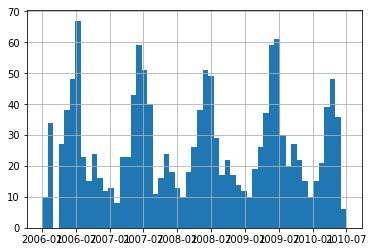

In [5]:
train['SaleDate'].hist(bins=55)

In [6]:
n_transaction=train.groupby('SaleDate').size()

let's see if the number of transaction in the same month affect the results.
other possibilities:
    1. summer variable
    2. economic crisis variable

In [7]:
train['n_transaction']=n_transaction.loc[train.SaleDate].values
train['Log_sale_price']=np.log10(train.SalePrice)
train.drop('SalePrice', axis=1, inplace=True)

In [8]:
columns_to_keep=train.columns.tolist()
columns_to_keep.remove('Log_sale_price')
columns_to_keep.remove('Id')
columns_to_keep.remove('SaleDate')



X=train[columns_to_keep]
y=train.Log_sale_price
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

regressor_OLS = sm.OLS(y_train,x_train).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Log_sale_price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     65.55
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:59:37   Log-Likelihood:                 1633.7
No. Observations:                1022   AIC:                            -2955.
Df Residuals:                     866   BIC:                            -2186.
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage                   0.0002      0.000      1.662      0.097   -3.52e-05       0.000
LotArea                    7.329e-07   2.31e-07      3.176      0.002     2.8e-07    1.19e-06
YearRemodAdd                  0.0004      0.000      2.781      0.006       0.000       0.001
MasVnrArea                 1.541e-05   1.56e-05      0.991      0.322   -1.51e-05     4.6e-05
BsmtFinSF1                 1.779e-05   6.63e-06      2.683      0.007    4.78e-06    3.08e-05
BsmtFinSF2                 1.298e-05   1.04e-05      1.253      0.211   -7.35e-06    3.33e-05
BsmtUnfSF                   4.17e-06   6.17e-06      0.676      0.499   -7.94e-06    1.63e-05
TotalBsmtSF                3.494e-05   9.28e-06      3.764      0.000    1.67e-05    5.32e-05
1stFlrSF                  -2.658e-05   1.62e-05     -1.640      0.101   -5.84e-05    5.22e-06
2ndFlrSF                  -8.749e-06   1.46e-05     -0.598      0.550   -3.75e-05       2e-05
LowQualFinSF              -5.954e-06   3.27e-05     -0.182      0.855   -7.01e-05    5.82e-05
GrLivArea                 -4.128e-05   2.23e-05     -1.850      0.065   -8.51e-05    2.53e-06
BsmtFullBath                  0.0117      0.005      2.193      0.029       0.001       0.022
BsmtHalfBath                  0.0052      0.008      0.610      0.542      -0.011       0.022
FullBath                      0.0204      0.006      3.264      0.001       0.008       0.033
HalfBath                      0.0184      0.006      3.104      0.002       0.007       0.030
BedroomAbvGr                  0.3735      0.051      7.316      0.000       0.273       0.474
KitchenAbvGr                 -0.0574      0.013     -4.436      0.000      -0.083      -0.032
TotRmsAbvGrd                  0.0441      0.007      6.498      0.000       0.031       0.057
Fireplaces                    0.0124      0.005      2.421      0.016       0.002       0.023
GarageYrBlt                   0.0002      0.000      1.415      0.157   -8.72e-05       0.001
GarageArea                 6.023e-05   1.62e-05      3.721      0.000    2.85e-05     9.2e-05
WoodDeckSF                 5.892e-05   1.56e-05      3.766      0.000    2.82e-05    8.96e-05
OpenPorchSF                6.092e-06   2.94e-05      0.207      0.836   -5.16e-05    6.38e-05
EnclosedPorch              1.143e-05   3.18e-05      0.359      0.719    -5.1e-05    7.39e-05
3SsnPorch                  1.459e-05   6.26e-05      0.233      0.816      -0.000       0.000
ScreenPorch                9.714e-05   3.38e-05      2.873      0.004    3.08e-05       0.000
PoolArea                   8.563e-05    5.9e-05      1.452      0.147   -3.01e-05       0.000
MiscVal                    2.654e-06   3.11e-06      0.853      0.394   -3.45e-06    8.76e-06
Diff_in_Ext                   0.0030      0.008      0.387      0.699      

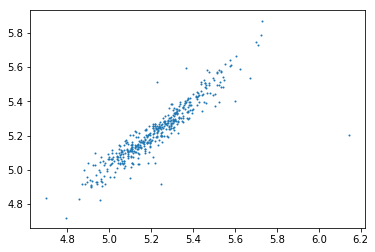

In [9]:
y_pred=regressor_OLS.predict(x_test)
plt.scatter(y_pred,y_test, s=1)

In [10]:
mse = mean_squared_error(y_pred,y_test)
rmse = np.sqrt(mse)
rmse

0.07145808631566884

n_transaction works but small. lets see if it remain after dropping var's

In [11]:
columns_to_keep2=train.columns.tolist()
columns_to_keep2.remove('Log_sale_price')
columns_to_keep2.remove('Id')
columns_to_keep2.remove('SaleDate')

X2=train[columns_to_keep2]
y2=train.Log_sale_price
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3,random_state=0)
x_train2.shape, x_test2.shape, y_train2.shape, y_test2.shape

((1022, 159), (438, 159), (1022,), (438,))

In [12]:
def backwardElimination(X, Y):
    for i in np.arange(0.9,0,-0.1):
        numVars = len(X.columns.tolist())
        d=[]
        regressor_OLS = sm.OLS(Y, X).fit()
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
    
    regressor_OLS = sm.OLS(Y, X).fit()
    while max(regressor_OLS.pvalues > i):
        numVars = len(X.columns.tolist())
        d=[]
        for j in range(numVars):
            if regressor_OLS.pvalues[j] > i:
                d.append(X.columns[j])
        for t in d:
            X=X.drop(t, axis=1)
        regressor_OLS = sm.OLS(Y, X).fit()
    
    print(regressor_OLS.summary())
    
    #predictions = regressor_OLS.predict(X)
    return regressor_OLS, X.columns.tolist()

regressor, ctp=backwardElimination(x_train2,y_train2)

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     143.8
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:59:42   Log-Likelihood:                 1606.8
No. Observations:                1022   AIC:                            -3066.
Df Residuals:                     948   BIC:                            -2701.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotArea               

0.07077458964875304

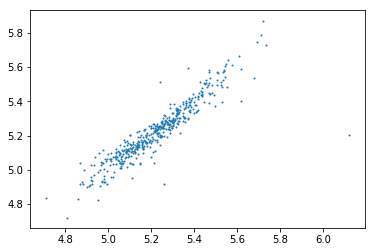

In [13]:
y_pred2=regressor.predict(x_test2[ctp])
plt.scatter(y_pred2,y_test2, s=1)

mse2 = mean_squared_error(y_pred2,y_test2)
rmse2 = np.sqrt(mse2)
rmse2

# data for USA house prices

let's add data regarding house prices in the usa. data is taken from here:
https://fred.stlouisfed.org/release?rid=171&t=monthly&ob=pv&od=desc

In [14]:
usa_sale_prices=pd.read_csv("../data/USA-House_prices_monthly_excat_dates.csv")
usa_sale_prices.head()

,DATE,HPIPONM226N
0,01/01/2006,219.40
1,01/02/2006,220.36
2,01/03/2006,222.03
3,01/04/2006,223.44
4,01/05/2006,225.28


In [15]:
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.DATE=usa_sale_prices.DATE.dt.strftime('%Y-%d-%m')
usa_sale_prices.DATE=pd.to_datetime(usa_sale_prices.DATE, infer_datetime_format=True)
usa_sale_prices.set_index('DATE', inplace=True)
train['Price_index']=usa_sale_prices.loc[train.SaleDate].values

In [16]:
def predicting(train, list_to_remove):
    columns_to_keep=train.columns.tolist()
    for i in list_to_remove:
        columns_to_keep.remove(i)

    X=train[columns_to_keep]
    y=train.Log_sale_price
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    x_train.shape, x_test.shape, y_train.shape, y_test.shape

    regressor_OLS = sm.OLS(y_train,x_train).fit()
    print(regressor_OLS.summary())
    
    y_pred=regressor_OLS.predict(x_test)
    mse = mean_squared_error(y_pred,y_test)
    rmse = np.sqrt(mse)
    print("\n rmse on all var's is: ", rmse)   
    
    regressor, ctp=backwardElimination(x_train,y_train)
    
    y_pred2=regressor.predict(x_test[ctp])
    mse2 = mean_squared_error(y_pred2,y_test2)
    rmse2 = np.sqrt(mse2)
    print("\n rmse on best var's is: ", rmse2)

    return y_pred, rmse, y_pred2,rmse2

In [17]:
y_pred, rmse, y_pred2,rmse2=predicting(train,['Log_sale_price','SaleDate', 'Id'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     65.21
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:59:44   Log-Likelihood:                 1634.9
No. Observations:                1022   AIC:                            -2956.
Df Residuals:                     865   BIC:                            -2182.
Df Model:                         156                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage           

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     143.6
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:59:49   Log-Likelihood:                 1606.1
No. Observations:                1022   AIC:                            -3064.
Df Residuals:                     948   BIC:                            -2699.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotArea               

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


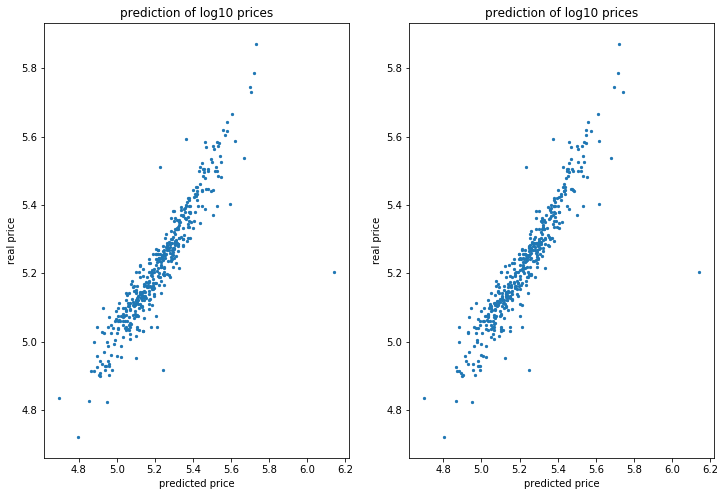

In [18]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.scatter(y_pred,y_test, s=5)
ax.set_title('prediction of log10 prices')
ax.set_xlabel('predicted price')
ax.set_ylabel('real price')

bx = fig.add_subplot(1,2,2)
bx.scatter(y_pred2,y_test2, s=5)
bx.set_title('prediction of log10 prices')
bx.set_xlabel('predicted price')
bx.set_ylabel('real price')

fig.show()

## loading test set and submmiting

In [19]:
test= pd.read_csv('../data/test.csv')

In [20]:
fix_year=test.loc[test.GarageYrBlt>2010].GarageYrBlt.index.values.tolist()
test.loc[fix_year,'GarageYrBlt']=np.nan

fix4=test[test.Exterior2nd=='Brk Cmn'].index.tolist()
test.loc[fix4,'Exterior2nd']='BrkComm'

fix5=test[test.Exterior2nd=='Wd Shng'].index.tolist()
test.loc[fix5,'Exterior2nd']='WdShing'

fix6=test[test.Exterior2nd=='CmentBd'].index.tolist()
test.loc[fix6,'Exterior2nd']='CemntBd'

test.loc[test[test.YearRemodAdd>test.YrSold].index, 'YearRemodAdd']=2007 


In [21]:
test.OverallCond=test.OverallCond.map(map_overall_to_cat)
test.OverallQual=test.OverallQual.map(map_overall_to_cat)
test['Diff_in_Ext']=test.apply(lambda x: 1 if x.Exterior2nd!=x.Exterior1st else 0, axis=1)

for c in cat_c:
    test=pd.concat([test,pd.get_dummies(test[c], prefix=c)], axis=1)

turn_MS_data_into_cat(test)

test=pd.concat([test,pd.get_dummies(test.BedroomAbvGr, prefix="br")], axis=1)

test['temp']=test.apply(lambda x: str(int(x.YrSold))+'-'+str(int(x.MoSold))+'-'+str(1), axis=1)
test['SaleDate']=pd.to_datetime(test['temp'])
test['n_transaction']=n_transaction.loc[test.SaleDate].values

test['120_RM']=0
test['Avg_room_size']=test.GrLivArea/test.TotRmsAbvGrd

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

['BsmtFinSF1', 'TotalBsmtSF', 'BsmtFullBath', 'GarageArea']

In [22]:
test.loc[test[test.BsmtFullBath.isnull()==True].index.tolist(),'BsmtFullBath']=0

test.loc[test[test.TotalBsmtSF.isnull()==True].index.tolist(),'TotalBsmtSF']=0

test.loc[test[test.BsmtFinSF1.isnull()==True].index.tolist(),'BsmtFinSF1']=0

test.loc[test[test.GarageArea.isnull()==True].index.tolist(),'GarageArea']=0

test_X=test[ctp]
test_X.loc[:,test_X.isnull().any()].columns.tolist()

[]

In [23]:
y_pred_test=regressor.predict(test_X)

y_pred_test.isnull().any()

False

In [24]:
SalePrice=pd.Series(10**y_pred_test, name='SalePrice')

test=test.join(SalePrice)

submission = test.loc[:, ['Id', 'SalePrice']].copy()
submission.set_index('Id', inplace=True)
submission.head()

,SalePrice
Id,
1461,110883.201374
1462,166423.681185
1463,179430.569905
1464,190531.781345
1465,177906.551509


In [25]:
#submission.to_csv('../data/model03.csv')

although n-transactions is statisticly valid it does not improve our submission score

# trying the AMES House prices index

got it from here- https://fred.stlouisfed.org/series/ATNHPIUS11180Q

In [26]:
Ames_sale_prices_Q=pd.read_csv("../data/Ames_House_prices.csv")
Ames_sale_prices_Q.DATE=pd.to_datetime(Ames_sale_prices_Q.DATE)
Ames_sale_prices_Q.head()

,DATE,ATNHPIUS11180Q
0,2005-01-01,148.10
1,2005-04-01,150.74
2,2005-07-01,153.74
3,2005-10-01,154.09
4,2006-01-01,153.82


In [27]:
timerange=[]
for i in range(2006,2011):
    for j in range(1,13):
        timerange.append(str(i)+'-'+str(j)+'-'+str(1))
timerange=pd.to_datetime(timerange)
timerange[:-5]

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01',
               '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01', '2006-11-01', '2006-12-01',
               '2007-01-01', '2007-02-01', '2007-03-01', '2007-04-01',
               '2007-05-01', '2007-06-01', '2007-07-01', '2007-08-01',
               '2007-09-01', '2007-10-01', '2007-11-01', '2007-12-01',
               '2008-01-01', '2008-02-01', '2008-03-01', '2008-04-01',
               '2008-05-01', '2008-06-01', '2008-07-01', '2008-08-01',
               '2008-09-01', '2008-10-01', '2008-11-01', '2008-12-01',
               '2009-01-01', '2009-02-01', '2009-03-01', '2009-04-01',
               '2009-05-01', '2009-06-01', '2009-07-01', '2009-08-01',
               '2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01'],
              dtype

In [28]:
Ames_sale_prices_M=pd.DataFrame(data=np.nan, index=np.arange(55), columns=['Date','Value'])
Ames_sale_prices_M.Date=timerange[:-5]
Ames_sale_prices_M.head()

,Date,Value
0,2006-01-01,NaN
1,2006-02-01,NaN
2,2006-03-01,NaN
3,2006-04-01,NaN
4,2006-05-01,NaN


In [29]:
Ames_sale_prices_M.set_index('Date', inplace=True)
Ames_sale_prices_M.head()

,Value
Date,
2006-01-01,NaN
2006-02-01,NaN
2006-03-01,NaN
2006-04-01,NaN
2006-05-01,NaN


In [30]:
Ames_sale_prices_Q.set_index('DATE', inplace=True)
Ames_sale_prices_Q.head()

,ATNHPIUS11180Q
DATE,
2005-01-01,148.10
2005-04-01,150.74
2005-07-01,153.74
2005-10-01,154.09
2006-01-01,153.82


In [31]:
Ames_sale_prices_M.Value=Ames_sale_prices_Q.loc[Ames_sale_prices_M.index].values
Ames_sale_prices_M

C:\Users\liort\Anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,Value
Date,
2006-01-01,153.82
2006-02-01,NaN
2006-03-01,NaN
2006-04-01,155.75
2006-05-01,NaN
2006-06-01,NaN
2006-07-01,153.31
2006-08-01,NaN
2006-09-01,NaN


In [32]:
def fancy_forward_fill(Ames_sale_prices_M):
    for i in range(0,52,3):
        v0=Ames_sale_prices_M.iloc[i].values
        v1=Ames_sale_prices_M.iloc[i+3].values
        j=(v1-v0)/3
        Ames_sale_prices_M.iloc[i+1]=v0+j
        Ames_sale_prices_M.iloc[i+2]=v0+(2*j)
fancy_forward_fill(Ames_sale_prices_M)

In [33]:
train['Price_index_Ames']=Ames_sale_prices_M.loc[train.SaleDate].values
train['Price_index_Ames']

0       159.236667
1       157.513333
2       156.570000
3       154.463333
4       158.453333
5       157.540000
6       157.420000
7       156.253333
8       157.730000
9       159.990000
10      159.236667
11      153.310000
12      156.570000
13      157.420000
14      157.243333
15      157.160000
16      156.053333
17      154.860000
18      156.756667
19      157.313333
20      154.773333
21      157.336667
22      156.570000
23      157.336667
24      157.306667
25      156.380000
26      157.306667
27      157.306667
28      154.686667
29      157.243333
           ...    
1430    153.310000
1431    157.540000
1432    157.420000
1433    157.243333
1434    154.936667
1435    156.270000
1436    157.513333
1437    157.586667
1438    157.240000
1439    158.623333
1440    156.570000
1441    157.243333
1442    157.780000
1443    157.313333
1444    158.623333
1445    157.513333
1446    157.240000
1447    159.306667
1448    157.513333
1449    153.826667
1450    157.153333
1451    157.

In [34]:
y_pred, rmse, y_pred2,rmse2=predicting(train,['Log_sale_price','SaleDate', 'Id','Price_index','n_transaction'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     65.22
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:59:56   Log-Likelihood:                 1631.4
No. Observations:                1022   AIC:                            -2951.
Df Residuals:                     866   BIC:                            -2182.
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage           

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     141.9
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:00:00   Log-Likelihood:                 1607.1
No. Observations:                1022   AIC:                            -3064.
Df Residuals:                     947   BIC:                            -2695.
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotArea               

In [44]:
def plotting_pred(y_pred,y_test):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(1,2,1)
    ax.scatter(y_pred,y_test, s=5)
    ax.set_title('prediction of log10 prices')
    ax.set_xlabel('predicted price')
    ax.set_ylabel('real price')

    bx = fig.add_subplot(1,2,2)
    bx.scatter(y_pred2,y_test2, s=5)
    bx.set_title('prediction of log10 prices')
    bx.set_xlabel('predicted price')
    bx.set_ylabel('real price')

    fig.show()

this data set does not provide ststistical valid result

# unemployment data for Ames
got it from here- https://fred.stlouisfed.org/series/AMES119URN

In [36]:
ue=pd.read_csv("../data/Unemployment in Ames.csv")
ue.head()

,DATE,AMES119URN
0,1990-01-01,3.9
1,1990-02-01,3.5
2,1990-03-01,3.3
3,1990-04-01,3.0
4,1990-05-01,3.4


In [38]:
ue.DATE=pd.to_datetime(ue.DATE)
ue.DATE.head()

0   1990-01-01
1   1990-02-01
2   1990-03-01
3   1990-04-01
4   1990-05-01
Name: DATE, dtype: datetime64[ns]

In [39]:
ue.set_index('DATE', inplace=True)
ue.head()

,AMES119URN
DATE,
1990-01-01,3.9
1990-02-01,3.5
1990-03-01,3.3
1990-04-01,3.0
1990-05-01,3.4


In [42]:
train['UnEmployment']=ue.loc[train.SaleDate].values
train['UnEmployment'].isnull().any()

False

In [45]:
y_pred, rmse, y_pred2,rmse2=predicting(train,['Log_sale_price','SaleDate', 'Id','Price_index'])

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     64.77
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:05:09   Log-Likelihood:                 1635.3
No. Observations:                1022   AIC:                            -2955.
Df Residuals:                     864   BIC:                            -2176.
Df Model:                         157                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotFrontage           

                            OLS Regression Results                            
Dep. Variable:         Log_sale_price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     143.6
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        22:05:14   Log-Likelihood:                 1606.1
No. Observations:                1022   AIC:                            -3064.
Df Residuals:                     948   BIC:                            -2699.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
LotArea               

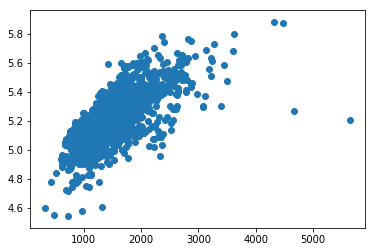

In [54]:
plt.scatter(train.GrLivArea,train.Log_sale_price)